## Parte I: Limpieza Base de Datos


#### Ejercicio 1
La base de datos provista contiene información sobre oferentes de Airbnb en la ciudad de Nueva York. Realicen una limpieza de la base.
- Tengan en cuenta si hay valores duplicados y eliminénlos.
- Eliminen las columnas que no tienen información de interés.
- (Opcional) Luego de leer el artículo __[Missing-data imputation](https://bookdown.org/mike/data_analysis/imputation-missing-data.html##imputation-missing-data)__ (__[Missing-data imputation articulo alternativo](http://www.stat.columbia.edu/~gelman/arm/missing.pdf)__), decidan qué hacer con los missing values e implementen su decision. Justifiquen su eleccion. Pueden usar informacion del paper mencionado o de otras fuentes (citenlas si las usan) para explicar los problemas que pueden surgir por su estrategia elegida.
- Si hay observaciones con *outliers* o valores que no tienen sentido, tomen una decision. Expliquen las decisiones tomadas.
- Transformen las variables **‘neighbourhood_group’** y **‘room_type’** a variables numericas.
- Con la ayuda de los comandos <code>groupby</code> y <code>join</code> o <code>merge</code>, creen una columna que tenga la cantidad de oferentes por “Neighbourhood group”. Llamen a esa nueva columna <code>offer group</code>

In [1]:
# Importo librerias necesarias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.experimental import enable_iterative_imputer  # Habilitar IterativeImputer
from sklearn.impute import IterativeImputer
from google.colab import files
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [2]:
files.upload()  # abre una ventana para subir el archivo

# Leer el archivo CSV
df = pd.read_csv('/content/Base Airbnb NY.csv')

Saving Base Airbnb NY.csv to Base Airbnb NY.csv


In [3]:
df. describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.890500e+04,4.890500e+04,48905.000000,48905.000000,48890.000000,48905.000000,48905.000000,38852.000000,48905.000000,48905.000000
mean,1.901697e+07,6.761671e+07,40.728949,-73.952172,152.725036,7.029077,23.274246,1.373213,7.142828,112.424149
std,1.098298e+07,7.860825e+07,0.054529,0.046153,240.164523,20.508561,44.547062,1.680309,32.949251,133.025799
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,-999.000000
25%,9.471997e+06,7.822683e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079133e+07,40.723080,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915163e+07,1.074344e+08,40.763120,-73.936280,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


### Valores duplicados

In [7]:
# Encuentra todas las filas duplicadas en el DataFrame
duplicados = df[df.duplicated()]

# Cantidad de duplicados
len(duplicados)

10

In [8]:
# Eliminar filas duplicadas y quedarse solo con la primera aparición de cada duplicado
df_sin_duplicados = df.drop_duplicates()

# Ver las primeras filas del DataFrame sin duplicados
df_sin_duplicados.head()

print(f"La cantidad original de filas era {len(df)}")
print(f"Al eliminar los duplicados queda un total de {len(df_sin_duplicados)} filas")

La cantidad original de filas era 48905
Al eliminar los duplicados queda un total de 48895 filas


### Columnas de interés


In [9]:
# Eliminamos las columnas que no son de interes

df_sin_duplicados.drop(["id", "name", "host_id", "host_name", "neighbourhood", "last_review"], axis=1, inplace=True)

<ipython-input-9-8b2661d7f055>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_sin_duplicados.drop(["id", "name", "host_id", "host_name", "neighbourhood", "last_review"], axis=1, inplace=True)


### Análisis exploratorio

In [27]:
df_sin_duplicados.describe()

,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000
mean,40.728122,-73.951193,139.259085,5.530077,28.885580,1.364511,5.163881,114.620244
std,0.055003,0.046633,131.574737,10.906626,46.190545,1.627428,26.286752,129.456513
min,40.506410,-74.244420,10.000000,1.000000,1.000000,0.010000,1.000000,0.000000
25%,40.688640,-73.982460,69.000000,1.000000,3.000000,0.190000,1.000000,0.000000
50%,40.721690,-73.954810,101.000000,2.000000,9.000000,0.720000,1.000000,55.000000
75%,40.762980,-73.935080,170.000000,4.000000,33.000000,2.010000,2.000000,229.000000
max,40.913060,-73.712990,2995.000000,270.000000,398.000000,17.820000,327.000000,365.000000


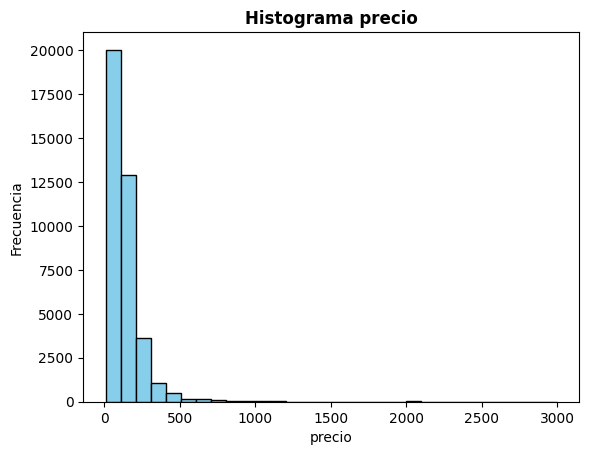

In [28]:
# precio
plt.hist(df_sin_duplicados["price"],bins=30, edgecolor='black', color='skyblue')
plt.xlabel('precio')
plt.ylabel('Frecuencia')
plt.title('Histograma precio', fontweight="bold")

# Mostrar el gráfico
plt.show()

In [29]:
print(f"Los datos mayores a 3000 son {len(df_sin_duplicados[df_sin_duplicados['price'] >= 3000])}")
print(f"Esto representa un {len(df_sin_duplicados[df_sin_duplicados['price'] >= 3000]) / len(df_sin_duplicados)*100}% de los datos")
print("\n")
print(f"Los datos iguales a 0 son {len(df_sin_duplicados[df_sin_duplicados['price'] == 0])}")

Los datos mayores a 3000 son 0
Esto representa un 0.0% de los datos


Los datos iguales a 0 son 0


In [30]:
# filtramos valores demasiado altos de "price" y lo que son = 0
df_sin_duplicados = df_sin_duplicados[df_sin_duplicados['price'] < 3000]
df_sin_duplicados = df_sin_duplicados[df_sin_duplicados['price'] != 0]

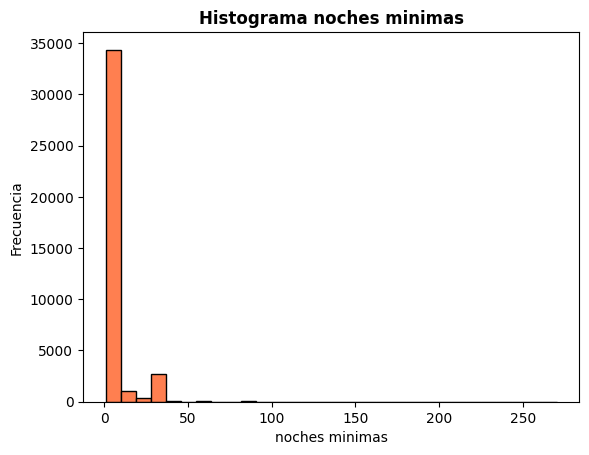

In [31]:
# Análisis exploratorio

# minimum_nights
plt.hist(df_sin_duplicados["minimum_nights"],bins=30, edgecolor='black', color='coral')
plt.xlabel('noches minimas')
plt.ylabel('Frecuencia')
plt.title('Histograma noches minimas', fontweight="bold")

# Mostrar el gráfico
plt.show()

In [32]:
print(f"Los datos mayores a 300 son {len(df_sin_duplicados[df_sin_duplicados['minimum_nights'] >= 300])}")
print(f"Representa un {len(df_sin_duplicados[df_sin_duplicados['minimum_nights'] >= 300]) / len(df_sin_duplicados)*100}% de los datos")

Los datos mayores a 300 son 0
Representa un 0.0% de los datos


In [33]:
# filtramos valores demasiado altos de "minimum_nights"
df_sin_duplicados = df_sin_duplicados[df_sin_duplicados['minimum_nights'] < 300]

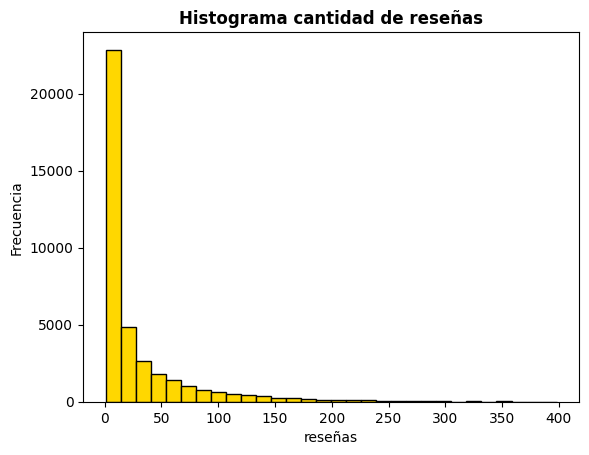

In [34]:
# Análisis exploratorio

# number_of_reviews
plt.hist(df_sin_duplicados["number_of_reviews"],bins=30, edgecolor='black', color='#FFD700')
plt.xlabel('reseñas')
plt.ylabel('Frecuencia')
plt.title('Histograma cantidad de reseñas', fontweight="bold")

# Mostrar el gráfico
plt.show()

In [35]:
print(f"Los datos mayores a 400 son {len(df_sin_duplicados[df_sin_duplicados['number_of_reviews'] >= 400])}")
print(f"Representa un {len(df_sin_duplicados[df_sin_duplicados['number_of_reviews'] >= 400]) / len(df_sin_duplicados)*100}% de los datos")

Los datos mayores a 400 son 0
Representa un 0.0% de los datos


In [36]:
# filtramos valores demasiado altos de "number_of_reviews"

df_sin_duplicados = df_sin_duplicados[df_sin_duplicados['number_of_reviews'] < 400]

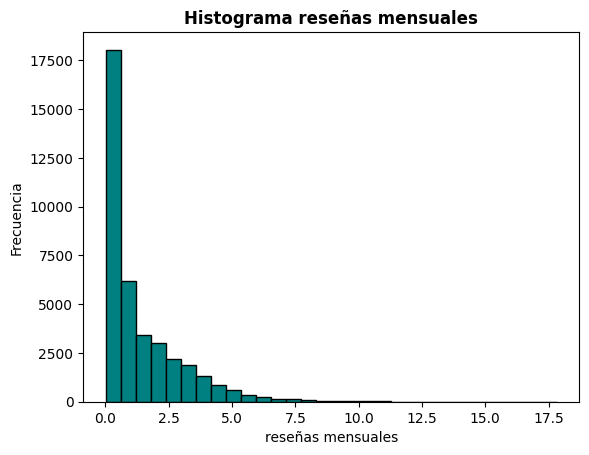

In [37]:
# Análisis exploratorio

# reviews_per_month
plt.hist(df_sin_duplicados["reviews_per_month"],bins=30, edgecolor='black', color='#008080')
plt.xlabel('reseñas mensuales')
plt.ylabel('Frecuencia')
plt.title('Histograma reseñas mensuales', fontweight="bold")

# Mostrar el gráfico
plt.show()

In [38]:
print(f"Los datos mayores a 20 son {len(df_sin_duplicados[df_sin_duplicados['reviews_per_month'] >= 20])}")
print(f"Representa un {len(df_sin_duplicados[df_sin_duplicados['reviews_per_month'] >= 20]) / len(df_sin_duplicados)*100}% de los datos")

Los datos mayores a 20 son 0
Representa un 0.0% de los datos


In [39]:
# filtramos valores demasiado altos de "reviews_per_month"
df_sin_duplicados = df_sin_duplicados[df_sin_duplicados['reviews_per_month'] < 20]

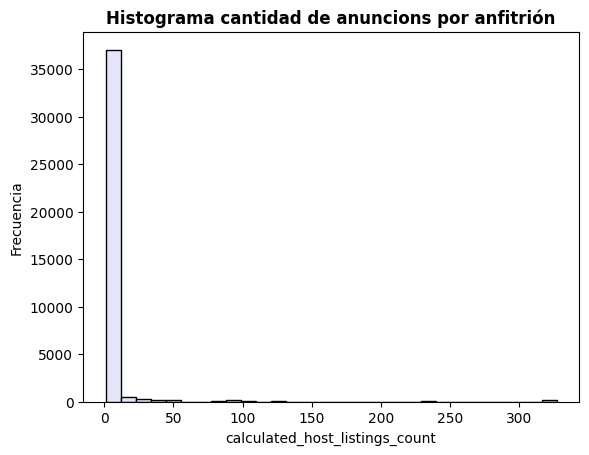

In [40]:
# Análisis exploratorio

# calculated_host_listings_count
plt.hist(df_sin_duplicados["calculated_host_listings_count"],bins=30, edgecolor='black', color='#E6E6FA')
plt.xlabel('calculated_host_listings_count')
plt.ylabel('Frecuencia')
plt.title('Histograma cantidad de anuncions por anfitrión', fontweight="bold")

# Mostrar el gráfico
plt.show()

In [41]:
print(f"Los datos mayores a 350 son {len(df_sin_duplicados[df_sin_duplicados['calculated_host_listings_count'] >= 350])}")
print(f"Representa un {len(df_sin_duplicados[df_sin_duplicados['calculated_host_listings_count'] >= 350]) / len(df_sin_duplicados)*100}% de los datos")

Los datos mayores a 350 son 0
Representa un 0.0% de los datos


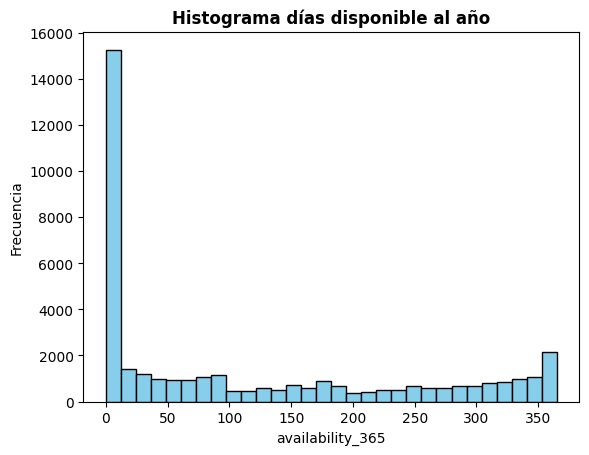

In [42]:
# Análisis exploratorio

# availability_365
plt.hist(df_sin_duplicados["availability_365"],bins=30, edgecolor='black', color='skyblue')
plt.xlabel('availability_365')
plt.ylabel('Frecuencia')
plt.title('Histograma días disponible al año', fontweight="bold")

# Mostrar el gráfico
plt.show()

In [43]:
# filtramos un valor atípico de "calculated_host_listings_count"
df_sin_duplicados = df_sin_duplicados[df_sin_duplicados['availability_365'] >= 0]

### Outliers

In [44]:
# Calculo e imprimo cantidad de outliers
# Seleccionar solo las columnas numéricas
df_numerico = df_sin_duplicados.select_dtypes(include=['number']);

# Eliminamos la columna "minimum_nights" porque tiene muchos 0
df_numerico.drop(["minimum_nights"], axis=1, inplace=True)

# aplicamos transformaciones logaritmicas
df_numerico["price"] = np.log(df_numerico["price"])

# Calcular el IQR
Q1 = df_numerico.quantile(0.25)
Q3 = df_numerico.quantile(0.75)
IQR = Q3 - Q1;

# Identificar los outliers usando un factor de 3
outliers = ((df_numerico < (Q1 - 3 * IQR)) | (df_numerico > (Q3 + 3 * IQR))).any(axis=1)

# Asegurarse de que los índices estén alineados con el DataFrame original
outliers_indices = df_numerico.index[outliers]

# Crear un nuevo DataFrame eliminando las filas con outliers del DataFrame original
df_sin_outliers = df_sin_duplicados.drop(outliers_indices)

# Mostrar el número de outliers
print(f'Número de outliers: {outliers.sum()}');

Número de outliers: 5952


In [45]:
df_numerico.describe()

,latitude,longitude,price,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000,38717.000000
mean,40.728122,-73.951193,4.695548,28.885580,1.364511,5.163881,114.620244
std,0.055003,0.046633,0.657435,46.190545,1.627428,26.286752,129.456513
min,40.506410,-74.244420,2.302585,1.000000,0.010000,1.000000,0.000000
25%,40.688640,-73.982460,4.234107,3.000000,0.190000,1.000000,0.000000
50%,40.721690,-73.954810,4.615121,9.000000,0.720000,1.000000,55.000000
75%,40.762980,-73.935080,5.135798,33.000000,2.010000,2.000000,229.000000
max,40.913060,-73.712990,8.004700,398.000000,17.820000,327.000000,365.000000


### Datos faltantes

In [46]:
# Calculo cantidad de datos faltantes

df_sin_outliers.isna().sum()

,0
neighbourhood_group,0
latitude,0
longitude,0
room_type,0
price,0
minimum_nights,0
number_of_reviews,0
reviews_per_month,0
calculated_host_listings_count,0
availability_365,0


In [47]:
# Eliminamos datos faltantes de "price" porque son pocos

# Eliminar filas donde 'price' es NaN
# df_sin_outliers = df_sin_outliers.dropna(subset=['price'])
# outliers_precio = df_sin_outliers["price"].isna().sum()
# print(df_sin_outliers)

# Contamos datos fantantes de nuevo
# print(f"La cantidad de datos faltantes en la columna price es: {outliers_precio}")

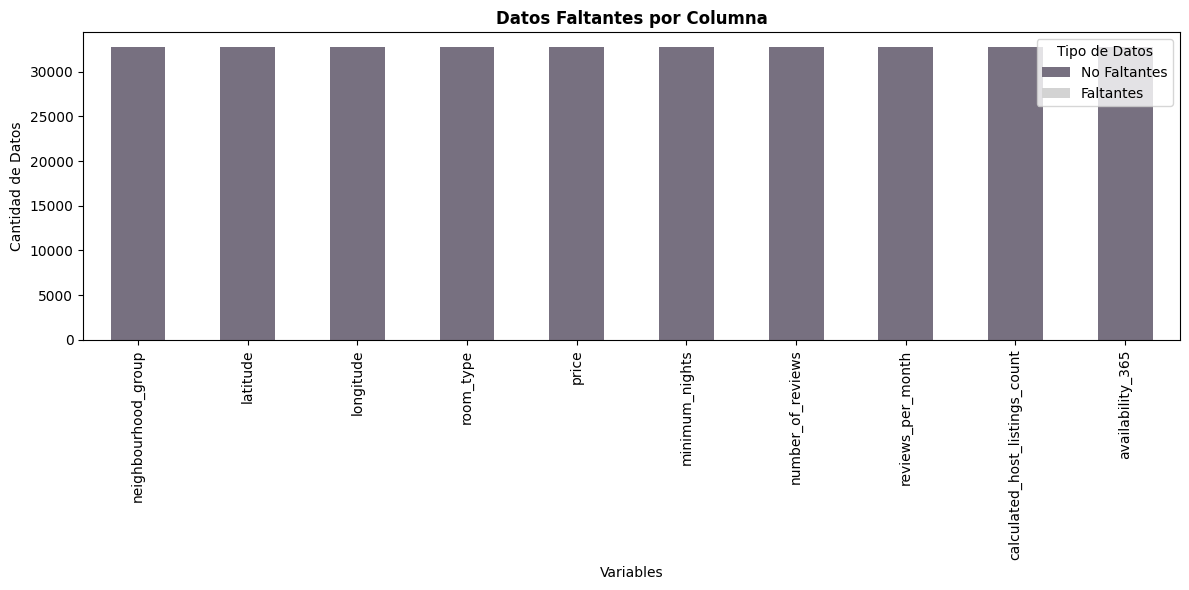

In [48]:
# Contar la cantidad de datos presentes y faltantes en cada columna
datos_faltantes = df_sin_outliers.isna().sum()
cantidad_datos = df_sin_outliers.shape[0]
datos_no_faltantes = cantidad_datos - datos_faltantes

# Crear un DataFrame para facilitar la visualización
cantidad_datos_FNF = pd.DataFrame({
    'No Faltantes': datos_no_faltantes,
    'Faltantes': datos_faltantes
})

# Crear gráfico de barras
cantidad_datos_FNF.plot(kind='bar', stacked=True, figsize=(12, 6), color=['#777080', '#D3D3D3'])

# Títulos y etiquetas
plt.title('Datos Faltantes por Columna', weight='bold')
plt.xlabel('Variables')
plt.ylabel('Cantidad de Datos')
plt.xticks(rotation=90)
plt.legend(title='Tipo de Datos')

# Mostrar gráfico
plt.tight_layout()
plt.show()

In [49]:
# Imputamos datos faltantes de 'reviews_per_month'

# Seleccionamos la columna 'reviews_per_month' para la imputación
df_reviews = df_sin_outliers[['reviews_per_month']].copy()

# Inicializar el IterativeImputer
imputer = IterativeImputer(random_state=42)

# Aplicar el imputador a la columna seleccionada
df_reviews_imputed = pd.DataFrame(imputer.fit_transform(df_reviews), columns=df_reviews.columns)

# Verificar los primeros resultados de la imputación
print(df_reviews_imputed)

       reviews_per_month
0                   0.38
1                   0.10
2                   0.59
3                   0.40
4                   0.99
...                  ...
32760               1.00
32761               1.00
32762               1.00
32763               2.00
32764               1.00

[32765 rows x 1 columns]


In [50]:
# Reemplazamos la columna original por la columna con datos imputados
df_sin_outliers['reviews_per_month'] = df_reviews_imputed["reviews_per_month"]
print(df_sin_outliers)

# Contamos datos fantantes de nuevo
outliers_RPM = df_sin_outliers["reviews_per_month"].isna().sum()
print(f"La cantidad de datos faltantes en la columna price es: {outliers_RPM}")

      neighbourhood_group  latitude  longitude        room_type  price  \
1               Manhattan  40.75362  -73.98377  Entire home/apt  225.0   
4               Manhattan  40.79851  -73.94399  Entire home/apt   80.0   
5               Manhattan  40.74767  -73.97500  Entire home/apt  200.0   
6                Brooklyn  40.68688  -73.95596     Private room   60.0   
8               Manhattan  40.80178  -73.96723     Private room   79.0   
...                   ...       ...        ...              ...    ...   
48732           Manhattan  40.71825  -73.99019  Entire home/apt  150.0   
48740            Brooklyn  40.69827  -73.99649  Entire home/apt  550.0   
48782           Manhattan  40.78099  -73.95366     Private room  129.0   
48805               Bronx  40.80787  -73.92400  Entire home/apt  100.0   
48852            Brooklyn  40.69805  -73.92801     Private room   30.0   

       minimum_nights  number_of_reviews  reviews_per_month  \
1                   1                 45        

### Variables categóricas
Transforar las variables ‘neighbourhood_group’ y ‘room_type’ a variables numericas.

In [51]:
# Para no asignar un valor de forma arbitraria usamos frequency encoding

# Calculamos las frecuencias de cada categoría en 'neighbourhood_group' y 'room_type'
# Reemplazamos las categorías con sus frecuencias

# neighbourhood_group
#neighbourhood_group_freq = df_sin_outliers['neighbourhood_group'].value_counts() / len(df_sin_outliers)
#df_sin_outliers['neighbourhood_group'] = df_sin_outliers['neighbourhood_group'].map(neighbourhood_group_freq)

#df_sin_outliers = df_sin_outliers.copy()  # Hacer una copia

# room_type
#room_type_freq = df_sin_outliers['room_type'].value_counts() / len(df_sin_outliers)
#df_sin_outliers['room_type'] = df_sin_outliers['room_type'].map(room_type_freq)

#print(df_sin_outliers)

In [52]:
# Para no asignar un valor de forma arbitraria los ordenamos según su precio promedio

# Calculamos el precio promedio de cada categoría en 'neighbourhood_group'
# Reemplazamos las categorías un orden

# neighbourhood_group
precio_prom_barrios = df_sin_outliers.groupby(['neighbourhood_group'])['price'].mean() #precio promedio
precio_prom_barrios = precio_prom_barrios.sort_values(ascending=False) # ordenamos según precio
precio_prom_barrios

,price
neighbourhood_group,
Manhattan,174.078685
Brooklyn,120.511924
Staten Island,98.691892
Queens,95.982398
Bronx,80.617801


In [53]:
# renombramos manualmente
df_sin_outliers['neighbourhood_group'].unique()
df_sin_outliers['neighbourhood_group'] = df_sin_outliers['neighbourhood_group'].replace({
    'Manhattan': 4,
    'Brooklyn': 3,
    "Staten Island": 2,
    "Queens": 1,
    "Bronx": 0
})

df_sin_outliers


<ipython-input-53-f4f3b438a5c9>:3: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sin_outliers['neighbourhood_group'] = df_sin_outliers['neighbourhood_group'].replace({


,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1,4,40.75362,-73.98377,Entire home/apt,225.0,1,45,0.10,2,355
4,4,40.79851,-73.94399,Entire home/apt,80.0,10,9,0.99,1,0
5,4,40.74767,-73.97500,Entire home/apt,200.0,3,74,0.43,1,129
6,3,40.68688,-73.95596,Private room,60.0,45,49,0.91,1,0
8,4,40.80178,-73.96723,Private room,79.0,2,118,4.44,1,0
...,...,...,...,...,...,...,...,...,...,...
48732,4,40.71825,-73.99019,Entire home/apt,150.0,4,1,NaN,1,13
48740,3,40.69827,-73.99649,Entire home/apt,550.0,3,1,NaN,1,230
48782,4,40.78099,-73.95366,Private room,129.0,1,1,NaN,1,147
48805,0,40.80787,-73.92400,Entire home/apt,100.0,1,2,NaN,1,40


In [54]:
# Calculamos el precio promedio de cada categoría en 'room_type'

# neighbourhood_group
precio_prom_cuartos = df_sin_outliers.groupby(['room_type'])['price'].mean() #precio promedio
precio_prom_cuartos = precio_prom_cuartos.sort_values(ascending=False) # ordenamos según precio
precio_prom_cuartos

,price
room_type,
Entire home/apt,191.801597
Private room,81.116529
Shared room,71.756140


In [55]:

# Reemplazamos las categorías por valores ordinales
# renombramos manualmente
df_sin_outliers['room_type'].unique()
df_sin_outliers['room_type'] = df_sin_outliers['room_type'].replace({
    'Entire home/apt': 2,
    'Private room': 1,
    'Shared room': 0,
})

df_sin_outliers

<ipython-input-55-0afe3e9ca8d0>:4: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_sin_outliers['room_type'] = df_sin_outliers['room_type'].replace({


,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
1,4,40.75362,-73.98377,2,225.0,1,45,0.10,2,355
4,4,40.79851,-73.94399,2,80.0,10,9,0.99,1,0
5,4,40.74767,-73.97500,2,200.0,3,74,0.43,1,129
6,3,40.68688,-73.95596,1,60.0,45,49,0.91,1,0
8,4,40.80178,-73.96723,1,79.0,2,118,4.44,1,0
...,...,...,...,...,...,...,...,...,...,...
48732,4,40.71825,-73.99019,2,150.0,4,1,NaN,1,13
48740,3,40.69827,-73.99649,2,550.0,3,1,NaN,1,230
48782,4,40.78099,-73.95366,1,129.0,1,1,NaN,1,147
48805,0,40.80787,-73.92400,2,100.0,1,2,NaN,1,40


### Cantidad de oferentes por “Neighbourhood group”

In [56]:
dic_barrios = {
    4: 'Manhattan',
    3: 'Brooklyn',
    2: "Staten Island",
    1: "Queens",
    0: "Bronx"
} # para luego llamar al nombre

In [57]:
# Añadir la columa Offer_group al data frame
# Contar la cantidad de veces que aparece cada categoría
contar_barrios = df_sin_outliers["neighbourhood_group"].value_counts().reset_index()

# Cambiar el nombre de las columnas
contar_barrios.columns = ['neighbourhood_group', 'offer_group']

# Hacer el merge con el DataFrame original
df_sin_outliers = df_sin_outliers.merge(contar_barrios, on='neighbourhood_group', how='left')

# Mostrar el resultado
print(df_sin_outliers)

       neighbourhood_group  latitude  longitude  room_type  price  \
0                        4  40.75362  -73.98377          2  225.0   
1                        4  40.79851  -73.94399          2   80.0   
2                        4  40.74767  -73.97500          2  200.0   
3                        3  40.68688  -73.95596          1   60.0   
4                        4  40.80178  -73.96723          1   79.0   
...                    ...       ...        ...        ...    ...   
32760                    4  40.71825  -73.99019          2  150.0   
32761                    3  40.69827  -73.99649          2  550.0   
32762                    4  40.78099  -73.95366          1  129.0   
32763                    0  40.80787  -73.92400          2  100.0   
32764                    3  40.69805  -73.92801          1   30.0   

       minimum_nights  number_of_reviews  reviews_per_month  \
0                   1                 45               0.10   
1                  10                  9     

In [58]:
# Contar la cantidad de veces que aparece cada categoría
conteo_categorias_barrio = df_sin_outliers["neighbourhood_group"].value_counts()

df_conteo = pd.DataFrame({'neighbourhood_group': conteo_categorias_barrio.index, 'conteo': conteo_categorias_barrio.values})
df_conteo['neighbourhood_group'] = df_conteo['neighbourhood_group'].map(dic_barrios)

# Mostrar el resultado
print(df_conteo)

  neighbourhood_group  conteo
0            Brooklyn   14592
1           Manhattan   13929
2              Queens    3295
3               Bronx     764
4       Staten Island     185


## Parte II: Graficos y visualizaciones

#### Ejercicio 2
Una vez hecha la limpieza, realicen una matriz de correlación con las siguientes variables:**‘neighbourhood group’, ‘latitude’, ‘longitude’, ‘room type’,‘price’, ‘minimum nights’, ‘number of reviews’, ‘reviews per month’,‘calculated host listings count’, ‘availability 365’.** Comenten los resultados. Utilicen alguno de los comandos disponibles en este link para graficar la matriz de correlacion.

*Nota:* consideren cómo es conveniente incluir las variables que originalmente eran categóricas para poder interpretar mejor la matriz de correlación.

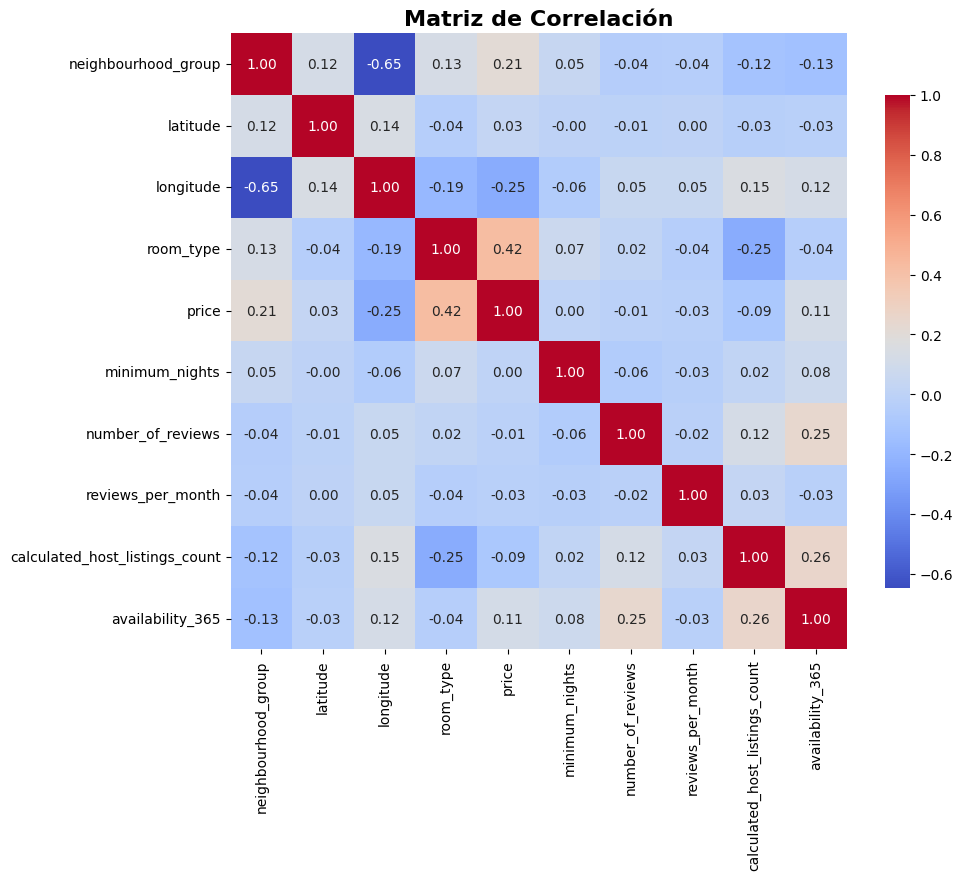

In [59]:
# Calculo matriz de correlación
df_matriz = df_sin_outliers[["neighbourhood_group", "latitude", "longitude","room_type", "price", "minimum_nights", "number_of_reviews", "reviews_per_month", "calculated_host_listings_count", "availability_365"]]

matriz_correlacion = df_matriz.corr(method='pearson')
matriz_correlacion

# Configuración del tamaño de la figura
plt.figure(figsize=(10, 8))

# Crear un mapa de calor (heatmap)
sns.heatmap(matriz_correlacion, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})

# Añadir título
plt.title('Matriz de Correlación', fontsize=16,  fontweight="bold")
plt.show()

#### Ejercicio 3
Respondan las siguientes preguntas: ¿Cuál es la proporción de oferentes por “Neighbourhood group”? ¿Y por tipo de habitación? Además, realicen gráficos para mostrar estas composiciones y comenten los resultados.

In [60]:
# Contar la cantidad de veces que aparece cada categoría de barrio

# Mostrar el resultado
print(conteo_categorias_barrio)
print("\n")

prop_conteo_barrios=conteo_categorias_barrio/len(df_sin_outliers["neighbourhood_group"])

# Crear un DataFrame con las proporciones y reemplazar los números por las etiquetas
df_prop_conteo_barrio = pd.DataFrame({'neighbourhood_group': conteo_categorias_barrio.index, 'proporcion': prop_conteo_barrios.values})
df_prop_conteo_barrio['neighbourhood_group'] = df_prop_conteo_barrio['neighbourhood_group'].map(dic_barrios)

# Mostrar la proporción de oferentes por barrio
print("Proporción de oferentes por barrio:")
print(df_prop_conteo_barrio)

neighbourhood_group
3    14592
4    13929
1     3295
0      764
2      185
Name: count, dtype: int64


Proporción de oferentes por barrio:
  neighbourhood_group  proporcion
0            Brooklyn    0.445353
1           Manhattan    0.425118
2              Queens    0.100565
3               Bronx    0.023318
4       Staten Island    0.005646


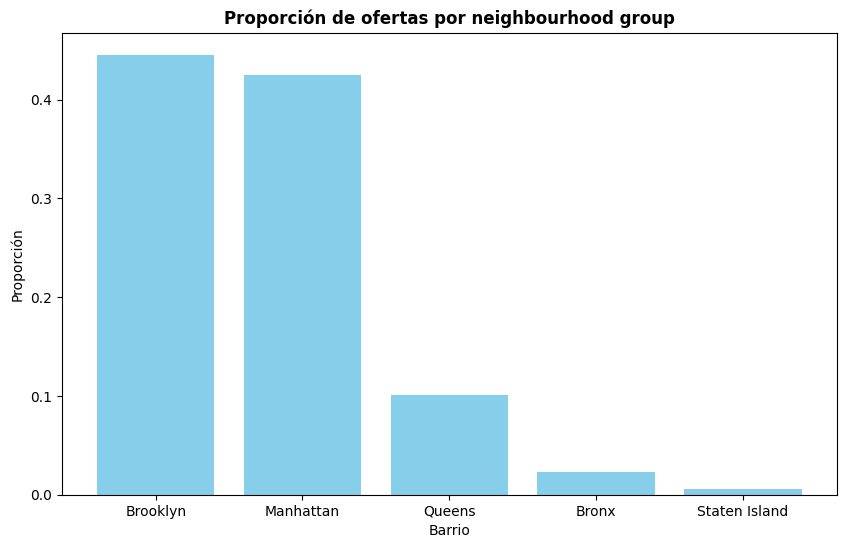

In [61]:
# graficamos proporciones barrios

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
#prop_conteo_barrios.plot(kind='bar', color='skyblue')

plt.bar(df_prop_conteo_barrio['neighbourhood_group'], df_prop_conteo_barrio['proporcion'], color='skyblue')

# Añadir título y etiquetas
plt.title('Proporción de ofertas por neighbourhood group', fontweight="bold")
plt.xlabel("Barrio")
plt.ylabel('Proporción')
plt.xticks(rotation=360)
plt.show();


In [62]:
dic_cuartos = {
    2: 'Entire home/apt',
    1: 'Private room',
    0: 'Shared room',
} # para luego llamar al nombre

In [63]:
# Contar la cantidad de veces que aparece cada categoría de cuarto
conteo_categorias_room = df_sin_outliers["room_type"].value_counts()

# Mostrar el resultado
print(conteo_categorias_room)
print("\n")

prop_conteo_cuartos=conteo_categorias_room/len(df_sin_outliers["room_type"])

# Crear un DataFrame con las proporciones y reemplazar los números por las etiquetas
df_prop_conteo_cuartos = pd.DataFrame({"room_type": conteo_categorias_room.index, 'proporcion': prop_conteo_cuartos.values})
df_prop_conteo_cuartos["room_type"] = df_prop_conteo_cuartos["room_type"].map(dic_cuartos)

# Mostrar la proporción de oferentes por barrio
print("Proporción de oferentes por tipo de cuarto:")
print(df_prop_conteo_cuartos)


room_type
2    17409
1    14786
0      570
Name: count, dtype: int64


Proporción de oferentes por tipo de cuarto:
         room_type  proporcion
0  Entire home/apt    0.531329
1     Private room    0.451274
2      Shared room    0.017397


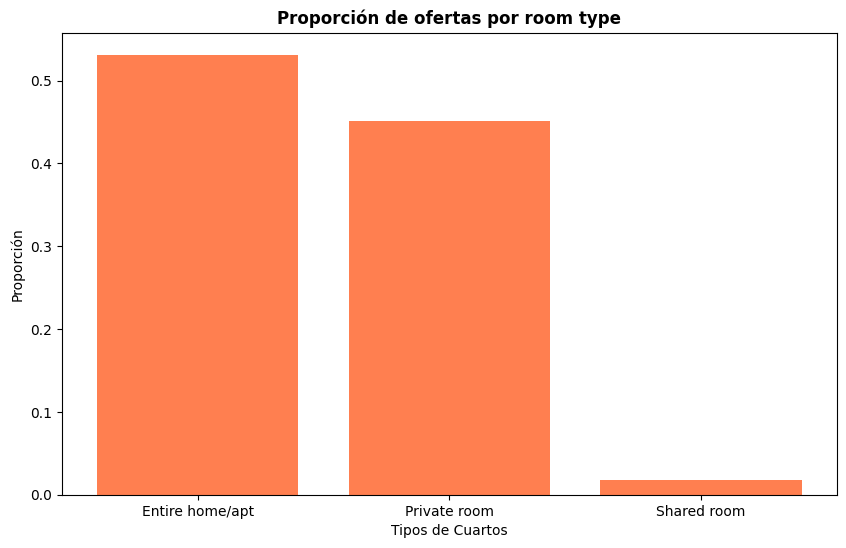

In [64]:
# graficamos proporciones barrios

# Crear un gráfico de barras
plt.figure(figsize=(10, 6))
# prop_conteo_cuartos.plot(kind='bar', color='coral')
plt.bar(df_prop_conteo_cuartos['room_type'], df_prop_conteo_cuartos['proporcion'], color='coral')

# Añadir título y etiquetas
plt.title('Proporción de ofertas por room type', fontweight="bold")
plt.xlabel("Tipos de Cuartos")
plt.ylabel('Proporción')
plt.xticks(rotation=360)
plt.show()

#### Ejercicio 4
Realicen un histograma de los precios de los alojamientos. Comenten el gráfico obtenido. Además, respondan las siguientes preguntas: ¿cuál es el precio mínimo, máximo y promedio? ¿Cuál es la media de precio por “Neighbourhood group” y por tipo de habitación?

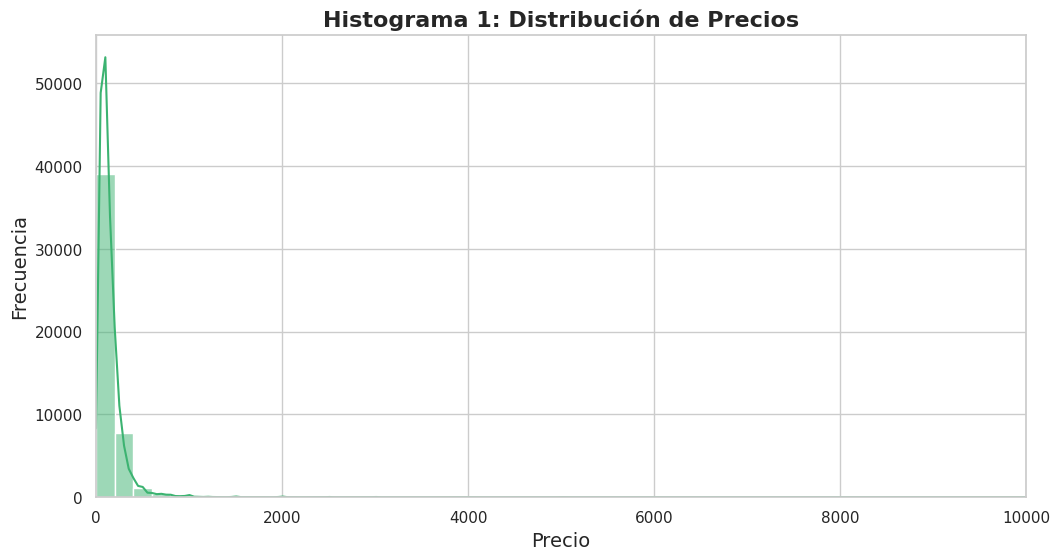

In [65]:
# Crear el histograma con la libreria seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(df["price"], bins=50, kde=True, color='#3CB371')

plt.title('Histograma 1: Distribución de Precios', fontsize=16,  fontweight="bold")
plt.xlabel('Precio', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

plt.xlim(0, df["price"].max())

# Mostrar el gráfico
plt.show()

In [66]:
# valor promedio
promedio = df["price"].mean()
print(f'El precio promedio es: {promedio}')

# Valor máximo
max_precio = df["price"].max()
print(f'El precio máximo es: {max_precio}')

# Valor mínimo
min_precio = df["price"].min()
print(f'El precio mínimo es: {min_precio}')

El precio promedio es: 152.72503579464103
El precio máximo es: 10000.0
El precio mínimo es: 0.0


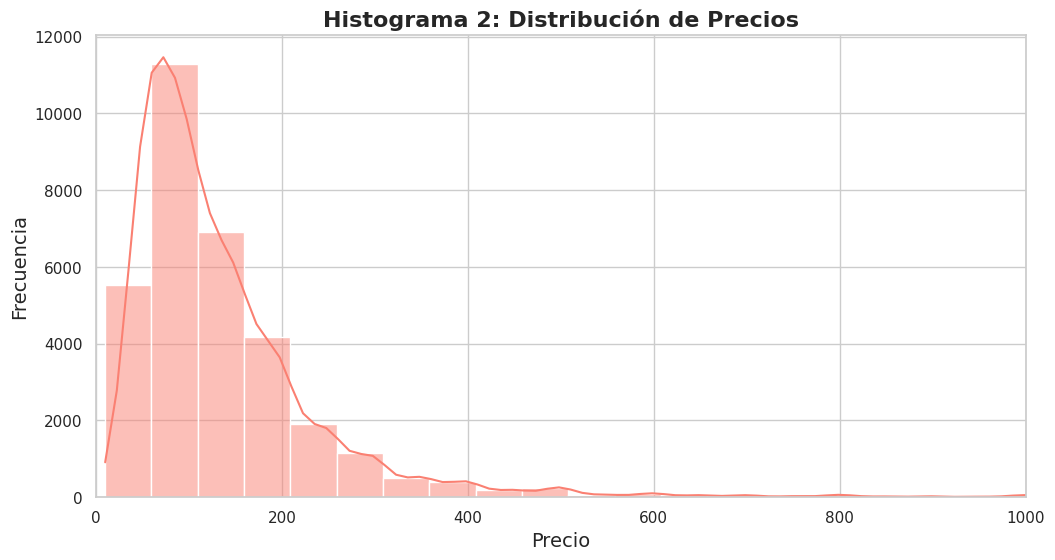

In [67]:
# Crear el histograma con la libreria seaborn
sns.set(style="whitegrid")
plt.figure(figsize=(12, 6))
sns.histplot(df_sin_outliers["price"], bins=50, kde=True, color='salmon')

plt.title('Histograma 2: Distribución de Precios', fontsize=16,  fontweight="bold")
plt.xlabel('Precio', fontsize=14)
plt.ylabel('Frecuencia', fontsize=14)

plt.xlim(0, 1000) # probamos acotar el rango de datos del eje X para una mejor visualización

# Mostrar el gráfico
plt.show()

In [68]:
# valor promedio
promedio2 = df_sin_outliers["price"].mean()
print(f'El precio promedio es: {promedio2}')

# Valor máximo
max_precio2 = df_sin_outliers["price"].max()
print(f'El precio máximo es: {max_precio2}')

# Valor mínimo
min_precio2 = df_sin_outliers["price"].min()
print(f'El precio mínimo es: {min_precio2}') # nota: eliminamos previamente 11 datos donde el precio = 0

El precio promedio es: 139.76389439951168
El precio máximo es: 2500.0
El precio mínimo es: 10.0


In [69]:
# Precio promedio por neighbourhood_group
print(f'Precio promedio por: {precio_prom_barrios}')
print ("\n")
# Precio promedio por room_type
print(f'Precio promedio por: {precio_prom_cuartos}')

Precio promedio por: neighbourhood_group
Manhattan        174.078685
Brooklyn         120.511924
Staten Island     98.691892
Queens            95.982398
Bronx             80.617801
Name: price, dtype: float64


Precio promedio por: room_type
Entire home/apt    191.801597
Private room        81.116529
Shared room         71.756140
Name: price, dtype: float64


#### Ejercicio 5
Realicen dos scatter plots con dos variables de interés en cada uno. Comenten.

In [70]:
df_sin_outliers.head()

,neighbourhood_group,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365,offer_group
0,4,40.75362,-73.98377,2,225.0,1,45,0.10,2,355,13929
1,4,40.79851,-73.94399,2,80.0,10,9,0.99,1,0,13929
2,4,40.74767,-73.97500,2,200.0,3,74,0.43,1,129,13929
3,3,40.68688,-73.95596,1,60.0,45,49,0.91,1,0,14592
4,4,40.80178,-73.96723,1,79.0,2,118,4.44,1,0,13929


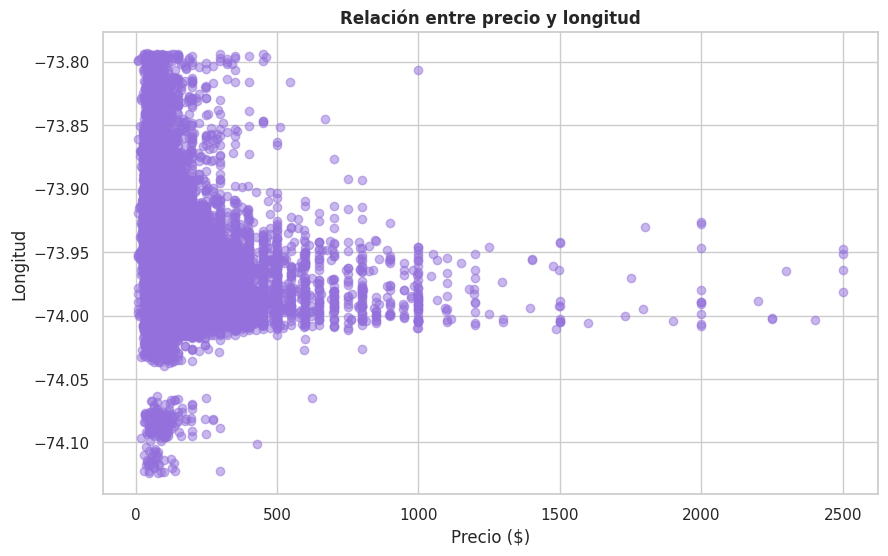

In [71]:
# Crear el scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(df_sin_outliers["price"], df_sin_outliers['longitude'], alpha=0.5, color='#9370DB')

# Título y etiquetas
plt.title('Relación entre precio y longitud',  fontweight="bold")
plt.ylabel("Longitud")
plt.xlabel('Precio ($)')

# Grilla
plt.grid(True)

# Mostrar el gráfico
plt.show()

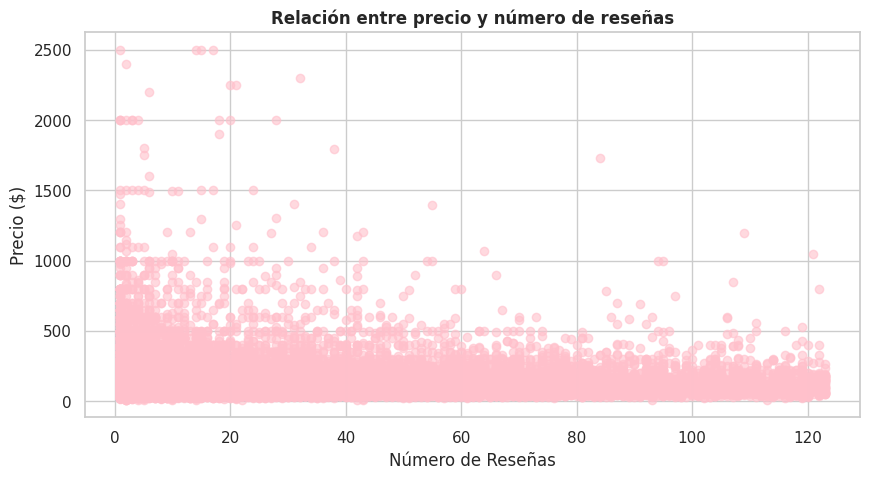

In [72]:
# Primer scatter plot: Relación entre el precio y el número de reseñas
plt.figure(figsize=(10, 5))
plt.scatter(df_sin_outliers['number_of_reviews'], df_sin_outliers['price'], color='#FFC0CB', alpha=0.6)

# Titulo y etiquetas
plt.title('Relación entre precio y número de reseñas',  fontweight="bold")
plt.ylabel('Precio ($)')
plt.xlabel('Número de Reseñas')

# Grilla
plt.grid(True)

# Mostrar gráfico
plt.show()

#### Ejercicio 6
Utilicen el análisis de componentes principales para graficar las variables en dos dimensiones. Comenten los resultados obtenidos (qué porcentaje de la varianza se logra explicar con dos componentes, cómo son los *loadings*, si ven algún patrón en el gráfico).

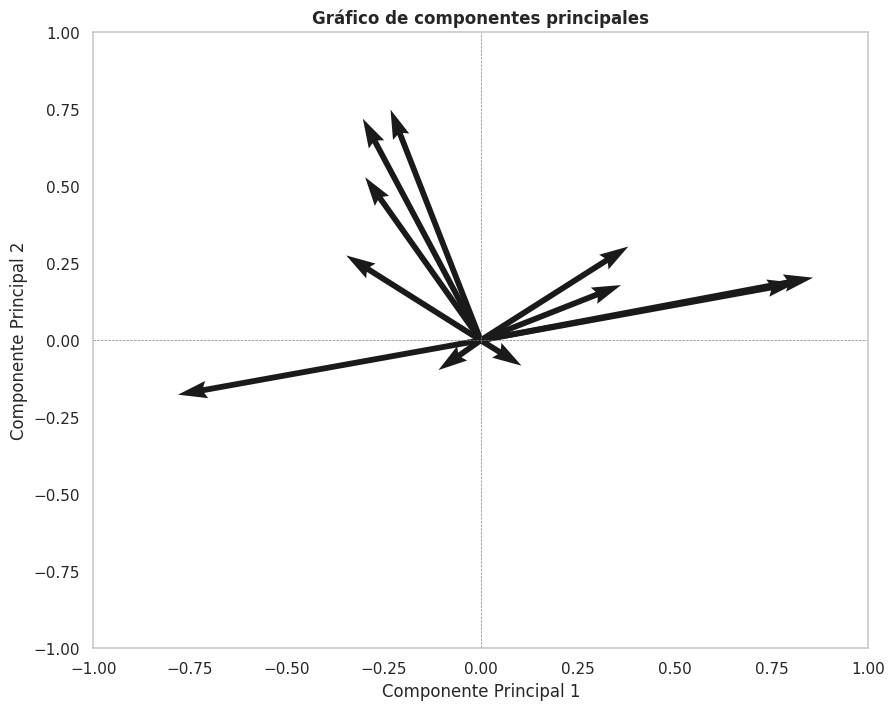

Porcentaje de varianza explicada por los dos primeros componentes: 39.52%


Loadings:
neighbourhood_group: [0.85755962 0.20323194]
latitude: [-0.10929707 -0.09692936]
longitude: [-0.78131473 -0.17677627]
room_type: [0.3621603 0.1792214]
price: [0.38095348 0.30441191]
minimum_nights: [ 0.10508361 -0.08251435]
number_of_reviews: [-0.2328023   0.74878326]
reviews_per_month: [-0.30425521  0.71930787]
calculated_host_listings_count: [-0.3471418   0.27537567]
availability_365: [-0.29835735  0.52948959]
offer_group: [0.81442587 0.18607574]


In [73]:
# Normalizar los datos
norm = StandardScaler()
df_sin_outliers['reviews_per_month'] = df_reviews_imputed["reviews_per_month"]
datos_normalizados = norm.fit_transform(df_sin_outliers)

# Calcular PCA
pca = PCA(n_components=2)
componentes_principales = pca.fit_transform(datos_normalizados)

# Crear un DataFrame para los componentes
pc_df = pd.DataFrame(data=componentes_principales, columns=['PC1', 'PC2'])

# Varianza explicada
varianza_explicada = pca.explained_variance_ratio_
varianza_explicada_total= np.sum(varianza_explicada[:2]) * 100

# Loadings
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)

# Gráfico de los componentes
plt.figure(figsize=(10, 8))
plt.quiver(np.zeros(loadings.shape[0]), np.zeros(loadings.shape[0]), loadings[:, 0], loadings[:, 1], angles='xy', scale_units='xy', scale=1)
plt.xlim(-1, 1)
plt.ylim(-1, 1)
plt.axhline(0, color='gray', lw=0.5, ls='--')
plt.axvline(0, color='gray', lw=0.5, ls='--')

# Titulos
plt.title('Gráfico de componentes principales',  fontweight="bold")
plt.xlabel('Componente Principal 1')
plt.ylabel('Componente Principal 2')
plt.grid()
plt.show()

print(f"Porcentaje de varianza explicada por los dos primeros componentes: {varianza_explicada_total:.2f}%")
print ("\n")

# Imprimir los loadings con el nombre de las variables
nombres_variables = df_sin_outliers.columns
print("Loadings:")
for nombre, loading in zip(nombres_variables, loadings):
    print(f"{nombre}: {loading}")

## Parte III: Predicción
El objetivo de esta parte del trabajo es intentar predecir los precios de los alojamientos.

#### Ejercicio 8
Partan la base en una base de prueba (test) y una de entrenamiento (train) utilizando el comando <code>train_test_split</code>. La base de entrenamiento debe comprender el 70% de los datos, y la semilla a utilizar (*random state instance*) debe ser 201. Establezca a price como su variable dependiente en la base de entrenamiento (vector y). El resto de las variables ser´an las variables independientes (matriz X). Recuerden agregar la columna de unos (1).

In [92]:
df_TT = df_sin_outliers.copy()

# Transformamos variables
df_TT["price"] = np.log(df_sin_outliers["price"])
# df_TT['minimum_nights'] = np.log(df_TT['minimum_nights'] + 1)
# df_TT['number_of_reviews'] = np.log(df_TT['number_of_reviews'] + 1)

In [93]:
from sklearn.model_selection import train_test_split
import numpy as np

# Definimos la variable dependiente y las independientes
y = df_TT["price"]

variables = ['latitude', 'longitude', 'minimum_nights',
             'number_of_reviews', 'calculated_host_listings_count',
             'availability_365']

X = df_TT[variables]

# Dividimos los datos en 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

# Ahora que X_train y X_test están definidos, agregamos una columna de unos
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

In [94]:
# Dividimos la base en test y train

# Definimos la variable dependiente y las independientes

y = df_TT["price"]

variables = ['latitude','longitude','minimum_nights',
       'number_of_reviews', 'calculated_host_listings_count',
       'availability_365']

x = df_TT[variables]

# Agregamos una columna de unos a X
X_train = np.hstack((np.ones((X_train.shape[0], 1)), X_train))
X_test = np.hstack((np.ones((X_test.shape[0], 1)), X_test))

# Dividimos los datos en 70% entrenamiento y 30% prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=201)

In [89]:
# Verificamos que se cumplan dimensiones

cantidad_total = X.shape[0]
cantidad_train = X_train.shape[0]
cantidad_test = X_test.shape[0]

print(f"Proporción entrenamiento: {round(cantidad_train / cantidad_total, 2)*100}%")
print(f"Proporción prueba: {round(cantidad_test  / cantidad_total, 2)*100}%")

Proporción entrenamiento: 70.0%
Proporción prueba: 30.0%


#### Ejercicio 9

Implementen una regresión lineal y comenten los resultados obtenidos.

In [95]:
# Creamos el modelo de regresión lineal
modelo = LinearRegression()

# Entrenamos el modelo con los datos de entrenamiento
modelo.fit(X_train, y_train)

# Predecir con los datos de prueba
y_pred = modelo.predict(X_test)

# Evaluamos el modelo
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)
print(f"Error cuadrático medio: {mse:.2f}")
print(f"R cuadrado: {r2:.2f}")

# Obtener e imprimir los coeficientes del modelo
coeficientes = modelo.coef_
intercepto = modelo.intercept_

print("\n")
print("Coeficientes del modelo:")
print(f"Intercepto: {intercepto}")
for variable, coef in zip(variables, coeficientes):
    print(f"{variable}: {coef}")

Error cuadrático medio: 0.35
R cuadrado: 0.19


Coeficientes del modelo:
Intercepto: -503.47334929895374
latitude: 1.1911005509343973
longitude: -6.2165587751942475
minimum_nights: -0.0016069391573129213
number_of_reviews: -2.9925803299302167e-05
calculated_host_listings_count: -0.10167046404832361
availability_365: 0.0009046428024150899


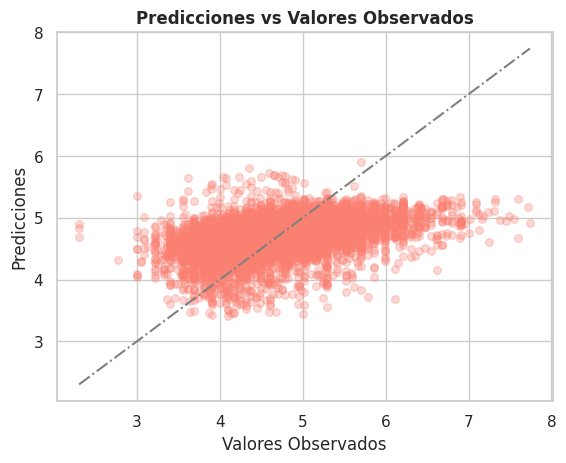

In [91]:
# Grafico de dispersión
plt.scatter(y_test, y_pred, color='salmon', s=30, alpha=0.3,  marker='o')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()],  '-.', color='gray')  # Línea referencia
plt.xlabel("Valores Observados")
plt.ylabel("Predicciones")
plt.title("Predicciones vs Valores Observados",  fontweight="bold")
plt.show();